In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib import cm
import csv
import scipy.io as sio
import pandas as pd
from scipy.special import erf
import time
import torch
import os

# plotting configuration
ratio = 1.7
figure_len, figure_width = 24*ratio, 18*ratio
title_font_size = 12*ratio
font_size_1, font_size_2 = 9*ratio, 9*ratio
legend_size = 18*ratio
line_width, tick_len = ratio, 4*ratio
marker_size = 5*ratio
plot_line_width = 2*ratio
hfont = {'fontname': 'Arial'}
marker_edge_width = 4
pal = sns.color_palette("deep")
sns.set(style='ticks')

In [2]:
def calc_distance(i, j):
    """calculate the distance between two neurons,
        i and j are the indices of two neurons, i and j are from 0 to N*N-1 (31*30),
        x1 and y1 are the coordinate for the first neuron, x1 and y1 are from 0 to 30.
    """
    N = 30
    x1, y1 = divmod(i, N)
    x2, y2 = divmod(j, N)

    xd = np.minimum(np.abs(x1 - x2), N - np.abs(x1 - x2))
    yd = np.minimum(np.abs(y1 - y2), N - np.abs(y1 - y2))
    return np.sqrt(xd**2 + yd**2)

def load_rate_field_data():
    # rate field data is used for plotting.
    # rate_field_data_spatially_compact is used for calculating the error and comparing with the analytical error.
    # unique_sorted_distances_degree_total is also used for plotting.
    
    N = 30
    center = int(((N+1)*N)/2) # index of the center
    distances_to_center = np.array([calc_distance(i, center) for i in range(N * N)]) # calculate the distance between every point in the 2D grid and the center
    sorted_distance_indices = np.argsort(distances_to_center) # indices of the sorted distance in the original array
    sorted_distances = distances_to_center[sorted_distance_indices] # the sorted distances
    sorted_distances_degree = sorted_distances*6 # the sorted distances in degree for all 900 neurons
    
    unique_sorted_distances_degree = np.asarray(sorted(set(sorted_distances_degree))) # remove the repetitive ones
    unique_sorted_distances_degree_left = -unique_sorted_distances_degree[::-1]
    unique_sorted_distances_degree_total = list(unique_sorted_distances_degree_left[:-1]) + list(unique_sorted_distances_degree)
    unique_sorted_distances_degree_total = np.asarray(unique_sorted_distances_degree_total) # the distance in degree, used for plotting
    
    l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
    n_stimulus = len(l_stimulus)
    l_celltype = ['E', 'PV', 'SST', 'VIP', 'L4', 'LM']

    l_baseline = sio.loadmat("data/baselines.mat")['baseline']
    rate_field_data_spatially_compact = np.zeros((22*9*6*2)) * np.nan # combined version, 22 spatial bins, 9 stimulus size, 4 cell types, 2 conditions
    rate_field_data = np.zeros((6, 18, 239)) * np.nan # 4 cell types, 18 stimulus conditions, number of unique location 120 *2 - 1

    for i in range(2):
        s_cond = 'classical' if i == 0 else 'inverse'

        for j in range(6):
            # activity
            rate_field_total = sio.loadmat('data/rate_field_activity_' + str(l_celltype[j]) + '.mat')['rate_field_activity']
            
            for k in range(n_stimulus):
                rate_field_instance = rate_field_total[9*i + k, :]
                rate_field_instance_left = rate_field_instance[::-1]
                rate_field_instance_intact = list(rate_field_instance_left[:-1]) + list(rate_field_instance)
                rate_field_data[j, i*9+k, :] = np.asarray(rate_field_instance_intact)

                for m in range(22): # 22 bins for different distance range
                    indices = np.where((unique_sorted_distances_degree >= m*6) & (unique_sorted_distances_degree < (m+1)*6))[0] 
                    
                    # first classical, then inverse; first different spatial bins, then different stimulus size, then different cell types
                    rate_field_data_spatially_compact[792*i + j*22*9+ k*22+m] = np.mean(rate_field_instance[indices] - l_baseline[0, j])
                    
    return rate_field_data, rate_field_data_spatially_compact, unique_sorted_distances_degree_total

### Fig. S1 - rate field data

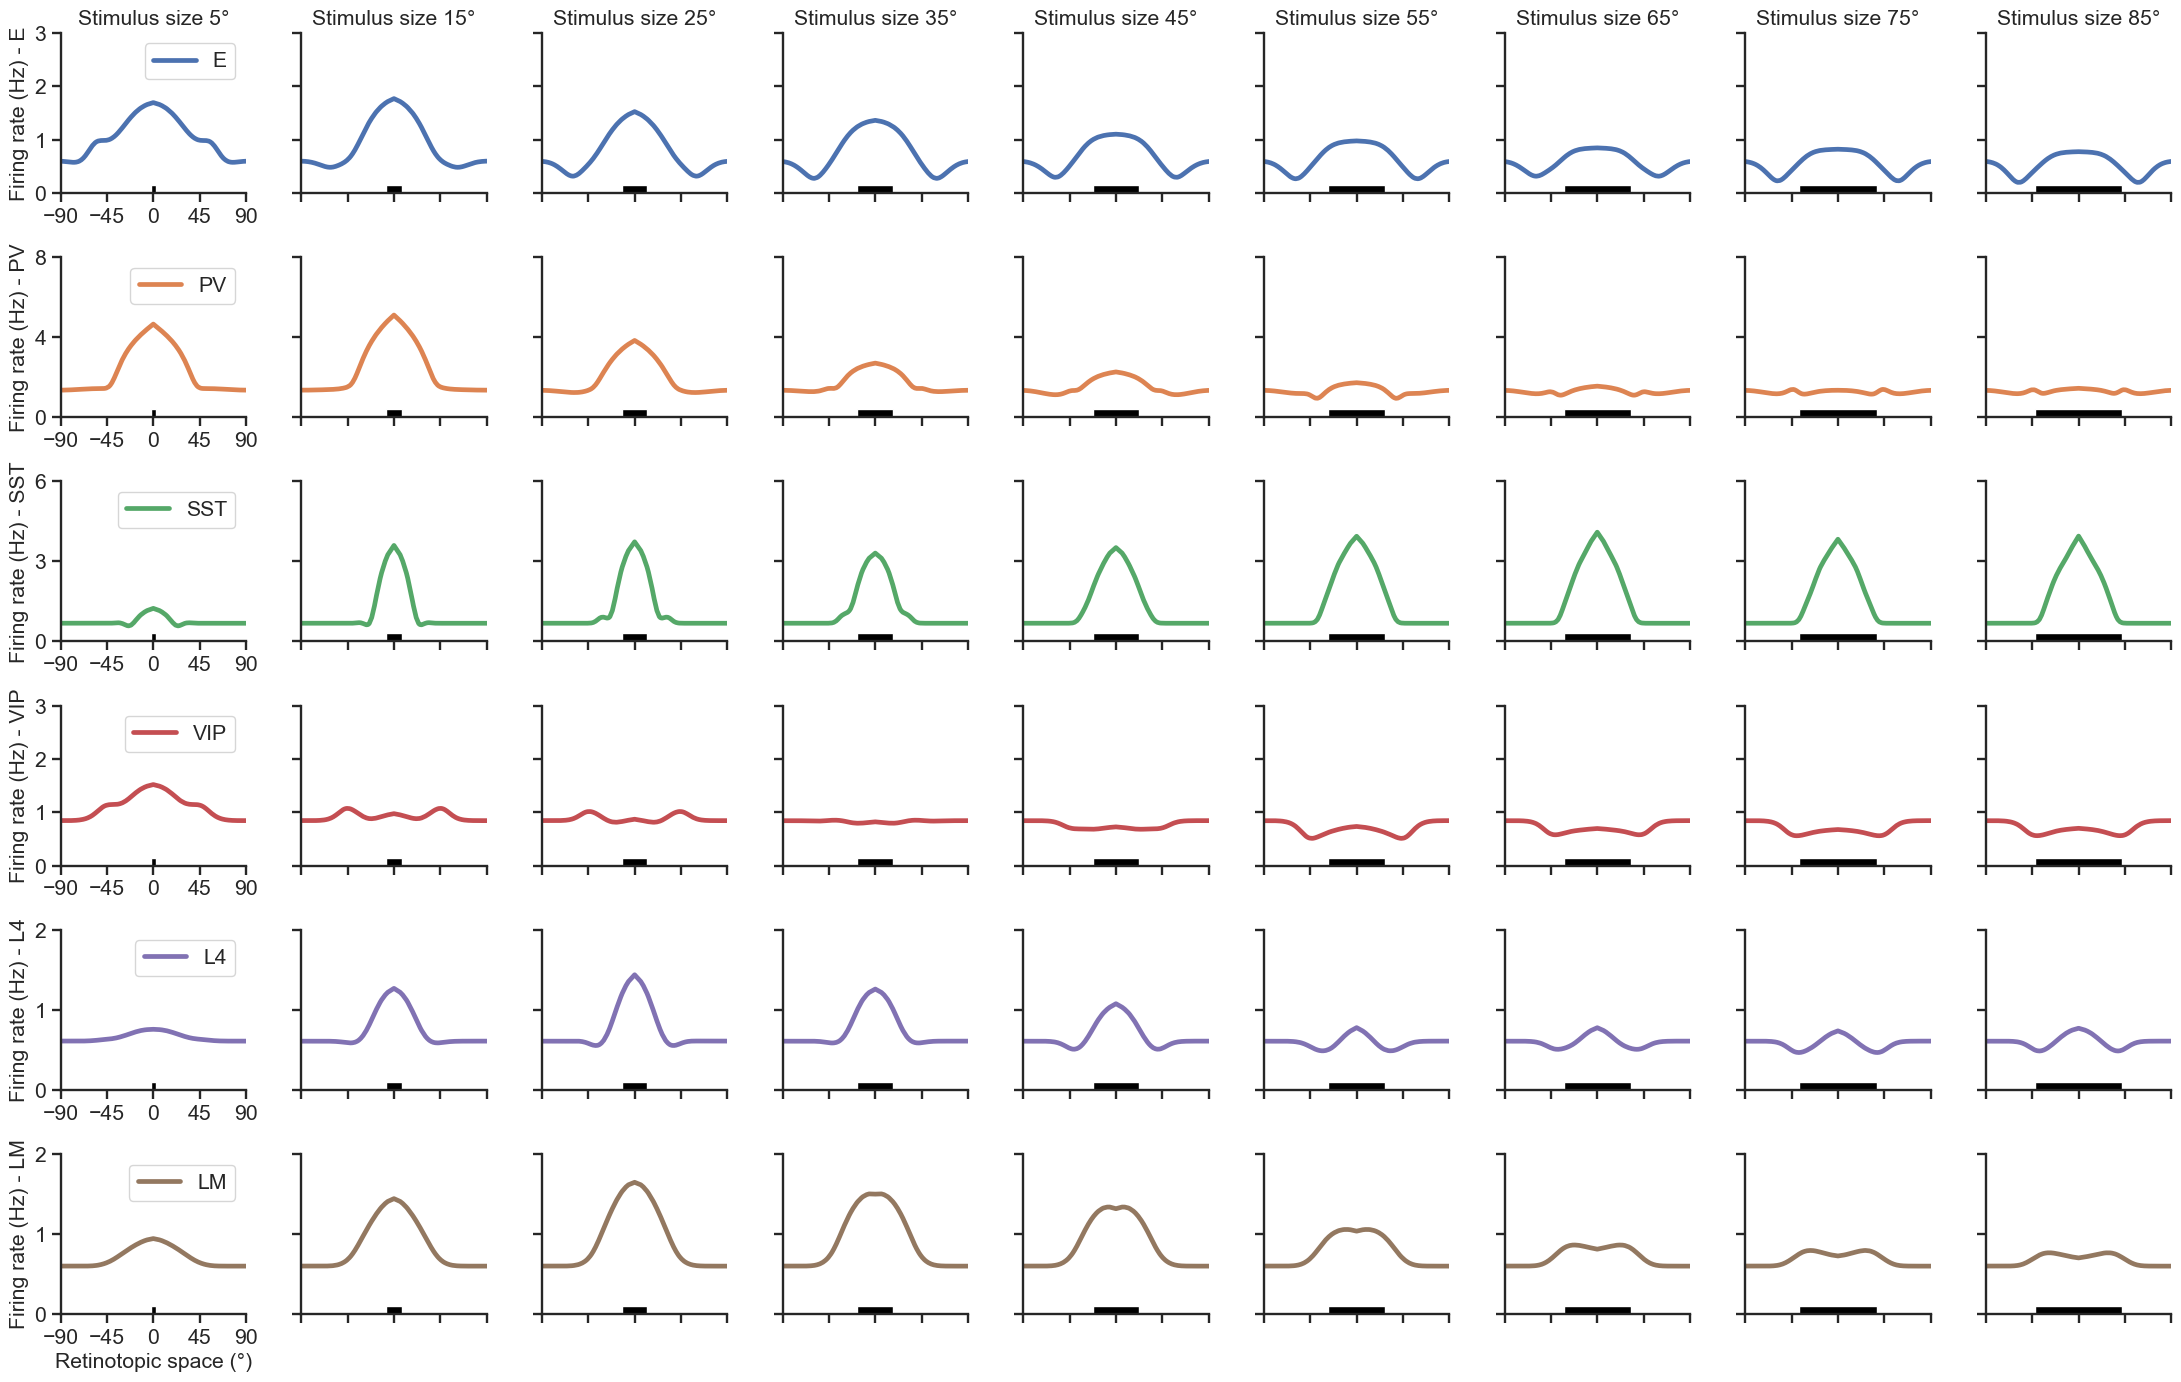

In [3]:
rate_field_data, rate_field_data_spatially_compact, unique_sorted_distances_degree_total = load_rate_field_data()

l_celltype = ['E', 'PV', 'SST', 'VIP', 'L4', 'LM']
l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

l_y_lowerlims = [0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3]

l_stim_type = [0]

for i in l_stim_type:
    s_cond = 'classical' if i == 0 else 'inverse'
#     fig, axes = plt.subplots(6, 9, figsize=(22*0.9, 13.5*0.9))
    fig, axes = plt.subplots(6, 9, figsize=(22, 13.5))
    fig.tight_layout()
    for j in range(6):

        for k in range(9):

            idx1, idx2 = j, k
            axes[idx1, idx2].spines['top'].set_visible(False)
            axes[idx1, idx2].spines['right'].set_visible(False)
            axes[idx1, idx2].spines['bottom'].set_visible(True)
            axes[idx1, idx2].spines['left'].set_visible(True)
            for axis in ['top', 'bottom', 'left', 'right']:
                axes[idx1, idx2].spines[axis].set_linewidth(line_width)
            axes[idx1, idx2].tick_params(width=line_width, length=tick_len)

            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, rate_field_data[j, i*9+k, :], linewidth=plot_line_width, color=pal[j])

            axes[idx1, idx2].set_xlim(-90, 90)
            axes[idx1, idx2].set_xticks([-90, -45, 0, 45, 90])
            if j == 0:
                axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                axes[idx1, idx2].set_ylim(0, 3)
            elif j == 1:
                axes[idx1, idx2].set_yticks([0, 4, 8])
                axes[idx1, idx2].set_ylim(0, 8)
            elif j == 2:
                axes[idx1, idx2].set_ylim(0, 6)
                axes[idx1, idx2].set_yticks([0, 3, 6])
            elif j == 3:
                axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                axes[idx1, idx2].set_ylim(0, 3)
            else:
                axes[idx1, idx2].set_yticks([0, 1, 2])
                axes[idx1, idx2].set_ylim(0, 2)

            if idx1 == 0:
                axes[idx1, idx2].set_title(f'Stimulus size {l_stimulus[k]}°', fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
            else:
                pass

            axes[idx1, idx2].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

            if idx2 == 0:
                axes[idx1, idx2].legend([l_celltype[j]], loc='upper right', prop={"family": "Arial", 'size': font_size_1})
                axes[idx1, idx2].set_ylabel('Firing rate (Hz) - ' + l_celltype[j], fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                # axes[idx1, idx2].set_ylabel('Firing rate (Hz)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
            else:
                axes[idx1, idx2].set_xticklabels([])
                axes[idx1, idx2].set_yticklabels([])
            
            if idx1 ==5 and idx2 == 0:
                axes[idx1, idx2].set_xlabel('Retinotopic space (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                
                
            y_limits = axes[idx1, idx2].get_ylim()
            if i == 0:
                # print(y_limits[1]-y_limits[0])
                rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='black', alpha=1)
            else:
                rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='red', alpha=1)

            axes[idx1, idx2].add_patch(rect)    

            for label in (axes[idx1, idx2].get_xticklabels() + axes[idx1, idx2].get_yticklabels()):
                label.set_fontname('Arial')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    # fig.savefig('paper_figures/paper_pdf/Fig_rate_fields_data.pdf', bbox_inches='tight')

### Fig. S2 - residual input

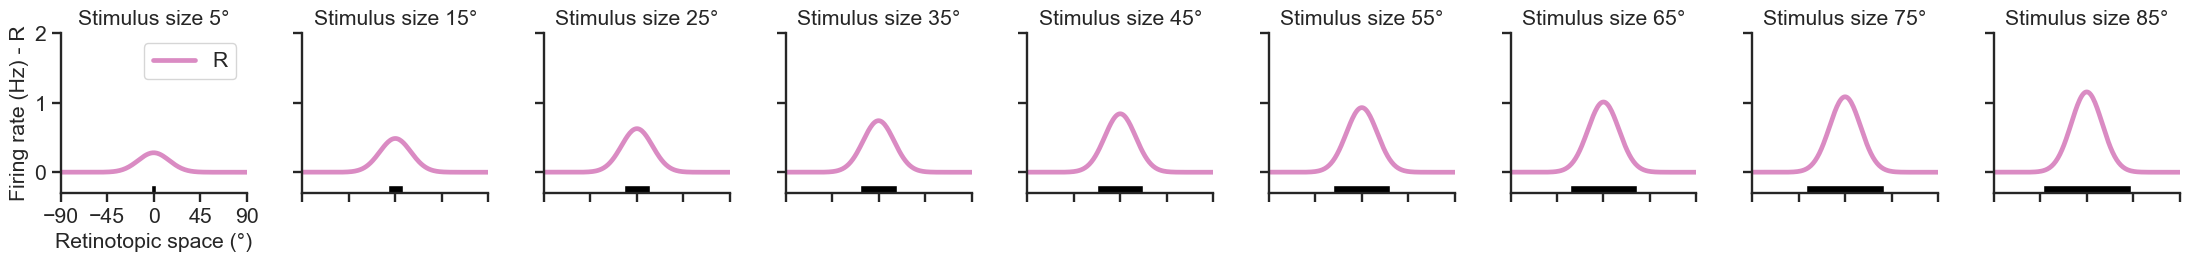

In [4]:
para_mat = np.zeros((9, 4)) * np.nan
para_mat[:, 0] = 1/8 * np.sqrt(np.asarray([5, 15, 25, 35, 45, 55, 65, 75, 85]))
para_mat[:, 1] = np.zeros(9)

para_mat[:, 2] = np.ones(9) * 15
para_mat[:, 3] = np.ones(9) * 15

l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
l_stimulus_label = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)

l_celltype = ['R']
l_y_lowerlims = [0, 0, 0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3, 3, 3]

l_cond = [1]

for i in l_cond:
    s_cond = 'Classical' if i == 0 else 'Inverse'
    fig, axes = plt.subplots(1, 9, figsize=(22, 2.29))
    fig.tight_layout()

    x = np.arange(-360, 361, 1)
    for k in range(9):

        idx = k
        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        axes[idx].spines['bottom'].set_visible(True)
        axes[idx].spines['left'].set_visible(True)
        for axis in ['top', 'bottom', 'left', 'right']:
            axes[idx].spines[axis].set_linewidth(line_width)
        axes[idx].tick_params(width=line_width, length=tick_len)

        axes[idx].plot(x, para_mat[k, 0] * np.exp(-np.power(x, 2)/(2 * para_mat[k, 2]**2)) - para_mat[k, 1] * np.exp(-np.power(x, 2)/(2 * para_mat[k, 3]**2)), linewidth=plot_line_width, color=pal[6])

        axes[idx].set_xlim(-90, 90)
        axes[idx].set_xticks([-90, -45, 0, 45, 90])

        axes[idx].set_ylim(-0.3, 2)
        axes[idx].set_yticks([0, 1, 2])

        axes[idx].set_title(f'Stimulus size {l_stimulus_label[k]}°', fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
        axes[idx].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

        if k==0:
            axes[idx].legend('R', loc='upper right', prop={"family": "Arial", 'size': font_size_1})
            axes[idx].set_xlabel('Retinotopic space (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
            axes[idx].set_ylabel('Firing rate (Hz) - ' + l_celltype[0], fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
        else:
            axes[idx].set_xticklabels([])
            axes[idx].set_yticklabels([])


        y_limits = axes[idx].get_ylim()
        rect = matplotlib.patches.Rectangle((-l_stimulus_label[k]/2, y_limits[0]), l_stimulus_label[k], (y_limits[1] - y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='black', alpha=1)
        axes[idx].add_patch(rect)    

        for label in (axes[idx].get_xticklabels() + axes[idx].get_yticklabels()):
            label.set_fontname('Arial')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
#     title_font_size = 16
#     fig.suptitle('Rate field of the residual input', y=1.15, fontsize=title_font_size, fontname='Arial')
# fig.savefig('paper_figures/paper_pdf/Fig_residual_rate_field.pdf', bbox_inches='tight')

### Fig. S12 - L4 and LM size-tuning curves

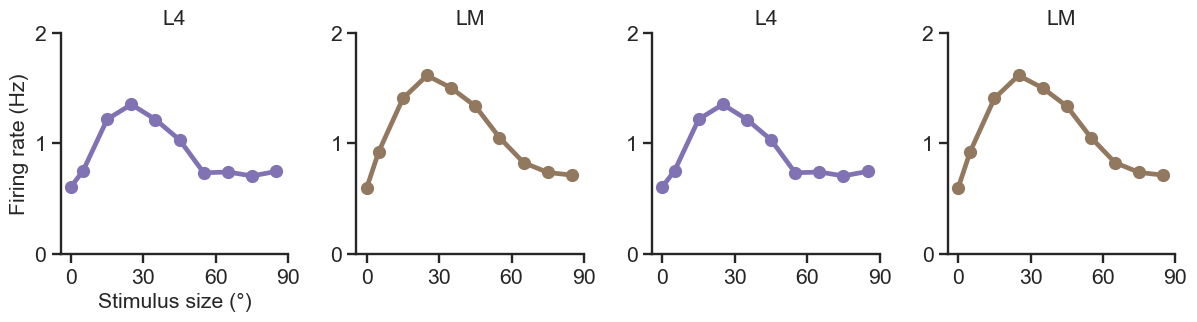

In [5]:
l_celltype = ['L4', 'LM', 'L4', 'LM']
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

size_tuning_data_classical = np.zeros((6, 10)) * np.nan
size_tuning_data_inverse = np.zeros((6, 9)) * np.nan
size_tuning_data_classical[:, 0] = l_baseline[0, :6]
size_tuning_data_classical[:, 1:] = rate_field_data[:, :9, 120]
size_tuning_data_inverse[:, :] = rate_field_data[:, 9:, 120]
l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)

l_stimulus_plot = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
   
fig, axes = plt.subplots(1, 4, figsize=(12, 2.9))
fig.tight_layout()

for j in range(4):
    idx = j

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].spines['bottom'].set_visible(True)
    axes[idx].spines['left'].set_visible(True)
    for axis in ['top', 'bottom', 'left', 'right']:
        axes[idx].spines[axis].set_linewidth(line_width)
    axes[idx].tick_params(width=line_width, length=tick_len)
    
    if j == 2:
        j = 0
        axes[idx].plot(l_stimulus_plot, size_tuning_data_classical[j+4, :], color=pal[j+4], linewidth=plot_line_width, zorder=2)
        for n in range(10):
            axes[idx].plot(l_stimulus_plot[n], size_tuning_data_classical[j+4, n], marker='o', color=pal[j+4], markersize=marker_size, zorder=2)
    elif j == 3:
        j = 1
        axes[idx].plot(l_stimulus_plot, size_tuning_data_classical[j+4, :], color=pal[j+4], linewidth=plot_line_width, zorder=2)
        for n in range(10):
            axes[idx].plot(l_stimulus_plot[n], size_tuning_data_classical[j+4, n], marker='o', color=pal[j+4], markersize=marker_size, zorder=2)
    else:
        axes[idx].plot(l_stimulus_plot, size_tuning_data_classical[j+4, :], color=pal[j+4], linewidth=plot_line_width, zorder=2)
        for n in range(10):
            axes[idx].plot(l_stimulus_plot[n], size_tuning_data_classical[j+4, n], marker='o', color=pal[j+4], markersize=marker_size, zorder=2)
    
            
    
    axes[idx].set_title(l_celltype[j], fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
    axes[idx].set_xticks([0, 30, 60, 90])

    axes[idx].set_yticks([0, 1, 2, 3])
    axes[idx].set_ylim(0, 2)

    if idx == 0:
        axes[idx].set_xlabel(f'Stimulus size (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
        axes[idx].set_ylabel('Firing rate (Hz)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

    axes[idx].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size
    for label in (axes[idx].get_xticklabels() + axes[idx].get_yticklabels()):
        label.set_fontname('Arial')

fig.subplots_adjust(hspace=0.4, wspace=0.3)
# title_font_size = 16
# fig.suptitle('Size-tuning curves - data', y=1.1, fontsize=title_font_size, fontname='Arial')
# fig.savefig('paper_figures/paper_pdf/Fig_size_tuning_curves_L4_LM.pdf', bbox_inches='tight')